In [49]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import numpyro
import numpyro.distributions as dist
import cvxpy as cvx
import torch
import matplotlib.pyplot as plt

from cryo_reweighting.examples.gaussian_mixture import GaussianMixture1D

# TODO: import functions from modules, e.g the expectation maximization or other optimization approaches
# TODO: Cruft to be thrown in and uncommented for jax things
#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
#os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"
##os.environ['CUDA_VISIBLE_DEVICES'] = ''   # To enable CPU backend
#from jax.lib import xla_bridge
#print("Device : ", xla_bridge.get_backend().platform)
## enable 16 bit precision for jax
#from jax import config
#config.update("jax_enable_x64", True)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data
### There will be more explanation here soon! Roughly speaking: the likelihood matrix shown comes from simulated images of a protein called [hsp90](https://en.wikipedia.org/wiki/Hsp90)
### The log likelihood matrix has entry n,m corresponding to the likelihood of image $y_n$ to arise from structure $x_m$
### Below are some examples of what the images look like

![title](data/hsp90_example.001.png)
![title](data/hsp90_example.002.png)




In [50]:
log_Pij = np.load("data/log_Pij_low_snr.npy") 
num_data, num_nodes = log_Pij.shape
print(f"number of images used: {num_data}")
print(f"number of structures used: {num_nodes}")


number of images used: 100000
number of structures used: 20


# Plot the ground truth solution for weights on structures
Here, $\theta$ is an angle that parametrizes the motion in the structures

Text(0.5, 1.0, 'True Probability Distribution')

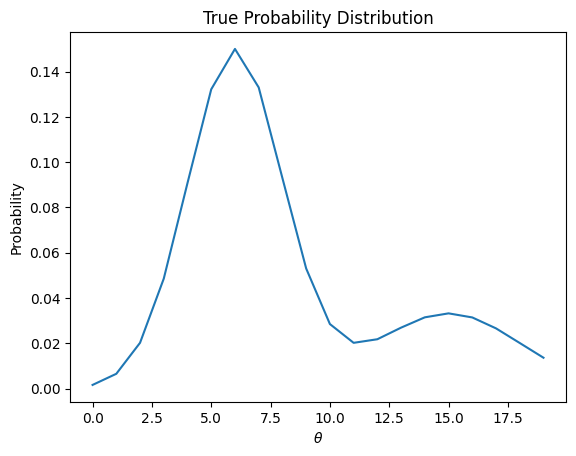

In [51]:
# Generate noisy data
weights = [3./4, 1./4]
means = [6.0, 15.0]
std_devs = [2.0, 3.0]
ground_truth_log_prob = GaussianMixture1D(weights, means, std_devs).log_prob

x = np.arange(0, 20, 1.0)
dx = x[1] - x[0]
ground_truth_prob = np.exp(ground_truth_log_prob(x)) / dx
plt.plot(x, ground_truth_prob)
plt.xlabel(r"$\theta$")
plt.ylabel("Probability")
plt.title("True Probability Distribution")

# Estimate Source Distribution

### Throw log-likelihood into method of choice: 
For now, these are in JAX

Three simple examples here (eventually):
1) Expectation Maxmimization on weights for the nodes
2) Whatever convex optmization is used by default in [cvxpy](https://www.cvxpy.org/index.html)
3) The naive "count how many images are assigned to a structure" method

In [52]:
# set initial weights
log_weights_init = np.log(np.ones_like(x)/num_nodes)

In [53]:
def normalize_weights(log_weights):
    """
    Gets the input vector log weights to sum to 1 when exponentionated, and returns exponentiated vector
    """
    weighted_alphas = jnp.exp(log_weights)
    weighted_alphas = weighted_alphas / jnp.sum(weighted_alphas)
    return weighted_alphas

def expectation_maximization_weights(log_Pij, log_weights_init=None, num_iterations=1000):
    """
    This function updates the weights according to the expectation maximization
     algorithm for mixture models.
    """

    num_data, num_nodes = log_Pij.shape
    if log_weights_init is None:
        log_weights = jnp.zeros((1, num_nodes))
    else:
        log_weights = log_weights_init
    log_weights = jnp.log(normalize_weights(log_weights))

    norms = np.zeros(num_iterations)
    loss = np.zeros(num_iterations)
    for k in range(num_iterations):
        log_likelihood_per_image = jax.scipy.special.logsumexp(log_Pij + log_weights, axis=1)
        log_weighted_likelihoods = log_Pij + log_weights
        log_posteriors = log_weighted_likelihoods - log_likelihood_per_image.reshape(num_data, 1)
        log_weights = jax.scipy.special.logsumexp(log_posteriors - jnp.log(num_data), axis=0)
        
        # compute two parameters to monitor for convergence: norm of weights, and log marginal likelihood
        norms[k] = jnp.linalg.norm(normalize_weights(log_weights))
        loss[k] = -1*(1/num_nodes)*jnp.sum(log_likelihood_per_image) 

    # Normalize weights and return log weights
    log_weights = jnp.log(normalize_weights(log_weights))
    return log_weights, norms, loss

def hard_assignment_estimator(log_Pij):
    """
    This estimates probabilities by simply 'histogramming' assignments of data to nodes
    """
    num_data, num_nodes = log_Pij.shape
    assignments = np.argmax(log_Pij, axis=1)
    return np.histogram(assignments, bins=num_nodes)[0] / num_data

(20,)


Text(0.5, 0, 'Iteration')

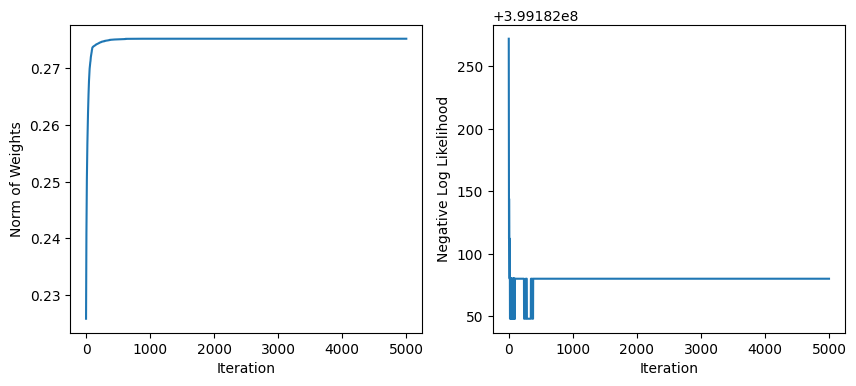

In [54]:
# solve with expectation maximization (em)
num_iterations = 5000
em_log_weights, norms, loss = expectation_maximization_weights(log_Pij, log_weights_init=log_weights_init, num_iterations=num_iterations)
em_weights = normalize_weights(em_log_weights)

# solve by counting assignments
hist_weights = hard_assignment_estimator(log_Pij)
print(hist_weights.shape)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
axes[0].plot(norms)
axes[0].set_ylabel("Norm of Weights")
axes[0].set_xlabel("Iteration")

axes[1].plot(loss)
axes[1].set_ylabel("Negative Log Likelihood")
axes[1].set_xlabel("Iteration")

# For the lowersnr example, there is likely a pretty big difference here!

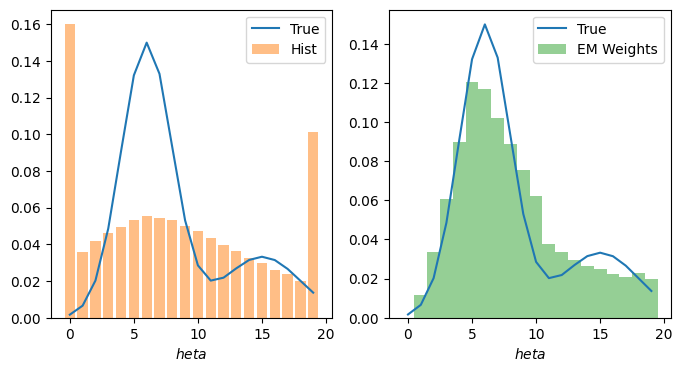

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
axes[0].bar(x, hist_weights/(x[1] - x[0]),  
             alpha=0.5, color="C1", label='Hist')

axes[1].bar(x, em_weights/(x[1] - x[0]), 
    width=dx, label='EM Weights', color="C2", alpha=0.5)

for ax in axes:
    ax.plot(x, ground_truth_prob, label='True', c='C0')
    ax.set_xlabel('$\theta$')
    ax.legend()
plt.legend()